# P_bar Notebook

In this notebook, I will change the order of coordinate transformation steps so that individuals are converted from a vertical coordinate of p to one of p_bar(rho). Then, after this has been done for individual temperature and salinity profiles, I will perform the rest of the analysis steps to calculate variance production, eddy diffusivity, and eddy fluxes. At some ppoint I'd also like to do a side-by-side comparison between the results for this order, and the order of moving to p_bar space at the end.

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.path import Path
import matplotlib.colors as colors
import pandas as pd
import numpy as np
from importlib import reload
import cartopy.crs as ccrs
import cmocean.cm as cmo
import gsw
import scipy.ndimage as filter
import scipy.interpolate as interpolate
from flox.xarray import xarray_reduce
#from xgcm.autogenerate import generate_grid_ds
from xgcm import Grid
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [93]:
import os
os.chdir('/home.ufs/amf2288/argo-intern/funcs')
import filt_funcs as ff
import density_funcs as df

In [2]:
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 16

## Load Dataset and Make Section

In [3]:
ds_x = xr.open_dataset('/swot/SUM05/amf2288/sync-boxes/ds_high_res_1.nc')

In [4]:
section = ds_x.where((ds_x.LATITUDE < -40) & (ds_x.LATITUDE > -50),drop=True).where((ds_x.LONGITUDE < 30) & (ds_x.LONGITUDE > 28),drop=True).sortby('LATITUDE')

In [5]:
section = section.sortby('N_PROF')

In [6]:
#only keep profiles with at least n data points
ct_counts = section['CT'].count(dim='PRES_INTERPOLATED')
profiles_to_keep = ct_counts >= 500
section_x = section.sel(N_PROF=profiles_to_keep).sortby('LATITUDE')

In [7]:
section_x

<xarray.Dataset> Size: 18MB
Dimensions:            (N_PROF: 284, PRES_INTERPOLATED: 1001)
Coordinates:
  * PRES_INTERPOLATED  (PRES_INTERPOLATED) int64 8kB 0 2 4 6 ... 1996 1998 2000
  * N_PROF             (N_PROF) int64 2kB 784410 784490 784432 ... 240154 238897
    TIME               (N_PROF) datetime64[ns] 2kB 2018-12-03T18:36:44 ... 20...
    LATITUDE           (N_PROF) float64 2kB -49.9 -49.87 ... -40.13 -40.12
    LONGITUDE          (N_PROF) float64 2kB 28.72 28.05 29.38 ... 28.34 29.48
Data variables:
    CT                 (N_PROF, PRES_INTERPOLATED) float64 2MB nan 3.508 ... nan
    CYCLE_NUMBER       (N_PROF, PRES_INTERPOLATED) float64 2MB nan 146.0 ... nan
    PLATFORM_NUMBER    (N_PROF, PRES_INTERPOLATED) float64 2MB nan ... nan
    PRES               (N_PROF, PRES_INTERPOLATED) float32 1MB nan 2.0 ... nan
    PSAL               (N_PROF, PRES_INTERPOLATED) float32 1MB nan 33.88 ... nan
    SA                 (N_PROF, PRES_INTERPOLATED) float64 2MB nan 34.04 ... nan
    SIG0               (N_PROF, PRES_INTERPOLATED) float64 2MB nan 26.95 ... nan
    TEMP               (N_PROF, PRES_INTERPOLATED) float32 1MB nan 3.502 ... nan
    sample_rate        (N_PROF, PRES_INTERPOLATED) float32 1MB nan 0.8 ... nan
    SPICE              (N_PROF, PRES_INTERPOLATED) float64 2MB nan ... nan
Attributes:
    DATA_ID:              ARGO
    DOI:                  http://doi.org/10.17882/42182
    Fetched_from:         https://data-argo.ifremer.fr
    Fetched_by:           amf2288
    Fetched_date:         2025/03/11
    Fetched_constraints:  [x=0.00/5.00; y=40.00/45.00; z=0.0/2002.0]
    Fetched_uri:          
    Valid uris:           ['https://data-argo.ifremer.fr/dac/coriolis/6903068...
    All uris:             ['https://data-argo.ifremer.fr/dac/coriolis/6903068...
    Processing_history:   [PRES,TEMP,PSAL] real-time and adjusted/delayed var...

## Coord interp to rho (density)

In [9]:
def interp_to_rho(rho_profile, var_profile, rho_grid, flag='group'):
    
    valid = ~np.isnan(rho_profile) & ~np.isnan(var_profile)
    rho_nonan = rho_profile[valid]
    var_nonan = var_profile[valid]

    if len(rho_nonan) < 3 or len(var_nonan) < 3:
        return np.full_like(rho_grid, np.nan)

    if flag == 'group':
        _, idx = np.unique(rho_nonan, return_index=True)
        rho_nonan = rho_nonan[idx]
        var_nonan = var_nonan[idx]

    fvar = interpolate.PchipInterpolator(rho_nonan, var_nonan, extrapolate=False)
    return fvar(rho_grid)

In [10]:
def get_ds_rho(ds_z, da_SIG0, rho_grid, variables, dim1='N_PROF', dim2='PRES'):

    xrs = []
    rho_size = rho_grid.size
    
    for var in variables:
        var_interp = xr.apply_ufunc(interp_to_rho, da_SIG0, ds_z[var],
            input_core_dims=[[dim2], [dim2]],
            output_core_dims=[['rho_grid']],
            dask_gufunc_kwargs={'output_sizes': {'rho_grid': rho_size}},
            vectorize=True,
            dask='parallelized',
            kwargs={'rho_grid': rho_grid},
            output_dtypes=[ds_z[var].dtype])
        print(f'Completed comp for {var}')
        var_interp = xr.DataArray(
            data=var_interp.data,
            dims=['N_PROF', 'rho_grid'],
            coords={'rho_grid': rho_grid, 'N_PROF': ds_z.N_PROF},
            name=var)
        xrs.append(var_interp)
        print(f'Completed {var}')
    
    ds_rho = xr.merge(xrs)
    print(f'Completed merge')
    ds_rho = ds_rho.assign_coords(LATITUDE  =(dim1, ds_z.LATITUDE.data))
    ds_rho = ds_rho.assign_coords(LONGITUDE =(dim1, ds_z.LONGITUDE.data))
    ds_rho = ds_rho.assign_coords(TIME      =(dim1, ds_z.TIME.data))
    
    return ds_rho

In [12]:
section_rho = get_ds_rho(section_x, section_x.SIG0, np.arange(21,29,0.0025), ['CT','SA','SIG0','SPICE','PRES','PRES_INTERPOLATED'], dim2='PRES_INTERPOLATED')

Completed comp for CT
Completed CT
Completed comp for SA
Completed SA
Completed comp for SIG0
Completed SIG0
Completed comp for SPICE
Completed SPICE
Completed comp for PRES
Completed PRES


/home.ufs/amf2288/miniforge3/envs/Argo_Feb_25/lib/python3.12/site-packages/numpy/lib/function_base.py:2506: RuntimeWarning: invalid value encountered in cast
  output[index] = result


Completed comp for PRES_INTERPOLATED
Completed PRES_INTERPOLATED
Completed merge


## Coord interp to pmean (average isopycnal depth)

NOTE!!! I modified this function to put calculating pmean_smooth in the get_ds_pmean function. This means that there is one density-depth relationship used for the whole region (which is what happens in a gridded section too, except that there's only one profile for each bin, so this is iterated through like the var profiles).

In [26]:
def interp_to_pmean(var_profile, pmean_smooth, pmean_grid, roll):

    try:
        valid = ~np.isnan(var_profile) & ~np.isnan(pmean_smooth)
        var_nonan = var_profile[valid]
        pmean_nonan = pmean_smooth[valid]

        # The ValueError is raised here if pmean_nonan is not strictly increasing.
        if len(pmean_nonan) < 3:
            return np.full_like(pmean_grid, np.nan)

        fvar = interpolate.PchipInterpolator(pmean_nonan, var_nonan, extrapolate=False)
        return fvar(pmean_grid)

    except ValueError:
        # Catch the error for this specific profile and return NaNs
        #print(f"ValueError")
        return np.full_like(pmean_grid, np.nan)

In [229]:
def get_ds_pmean(ds_rho, pmean_grid, variables, roll=50, dim1='N_PROF', dim2='rho_grid'):
    
    xrs = []
    pmean_size = pmean_grid.size
    
    pres_profile = ds_rho.PRES.mean(dim1)
    #pres_da = xr.DataArray(pres_profile, dims=['rho_grid'])
    pmean_smooth = pres_profile.rolling(**{dim2: roll}, center=True).mean()
    
    for var in variables:
        var_interp = xr.apply_ufunc(interp_to_pmean, ds_rho[var], pmean_smooth,
                                   input_core_dims=[[dim2], [dim2]],
                                   output_core_dims=[['Pmean_grid']],
                                   dask_gufunc_kwargs={'output_sizes': {'Pmean_grid':pmean_size}},
                                   vectorize=True,
                                   dask='parallaleized',
                                   kwargs={'pmean_grid':pmean_grid, 'roll':roll},
                                   output_dtypes=[ds_rho[var].dtype])
        print(f'Completed comp for {var}')
        var_interp = xr.DataArray(
            data=var_interp.data,
            dims=[dim1,'pmean_grid'],
            coords={'pmean_grid': pmean_grid, dim1: ds_rho[dim1]},
            name=var)
        xrs.append(var_interp)
        print(f'Completed {var}')
        
    ds_pmean = xr.merge(xrs)
    print(f'Completed merge')
    ds_pmean = ds_pmean.assign_coords(LATITUDE  = (dim1, ds_rho.LATITUDE.data))
    ds_pmean = ds_pmean.assign_coords(LONGITUDE = (dim1, ds_rho.LONGITUDE.data))
    ds_pmean = ds_pmean.assign_coords(TIME      = (dim1, ds_rho.TIME.data))
    
    return ds_pmean

In [68]:
section_pmean = get_ds_pmean(section_rho, np.linspace(0, 2000, 1001), ['CT','SA','SIG0','SPICE','PRES'])

Completed comp for CT
Completed CT
Completed comp for SA
Completed SA
Completed comp for SIG0
Completed SIG0
Completed comp for SPICE
Completed SPICE
Completed comp for PRES
Completed PRES
Completed merge


In [84]:
#section_x = section_x.rename({'PRES_INTERPOLATED':'depth','N_PROF':'prof'})
#section_rho = section_rho.rename({'rho_grid':'density','N_PROF':'prof'})
section_pmean = section_pmean.rename({'pmean_grid':'pmean','N_PROF':'prof'})

Text(0.5, 1.0, 'CT on p_bar')

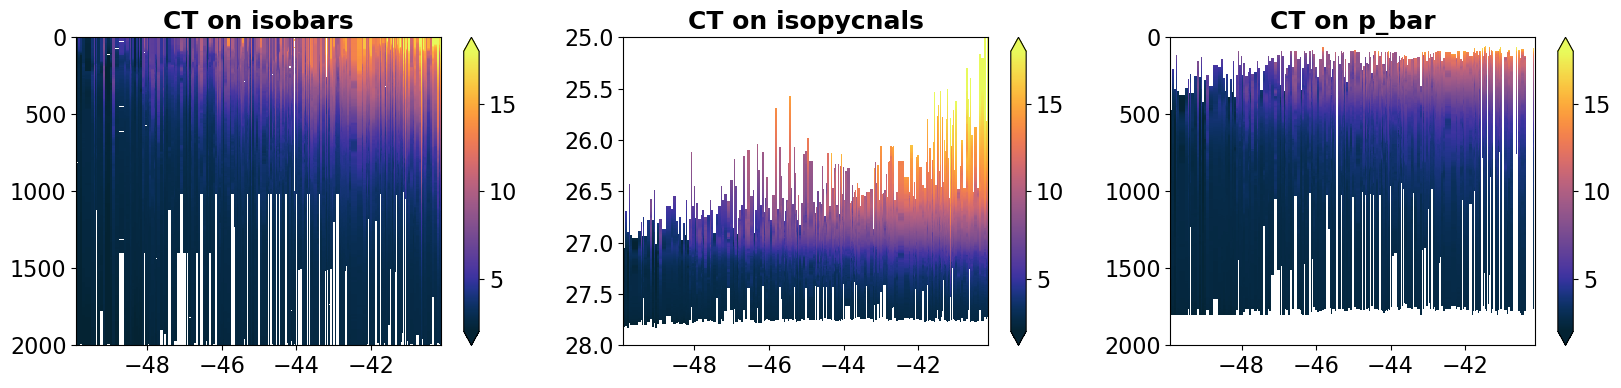

In [90]:
plt.figure(figsize=(20,4))
x = 'LATITUDE'
var = 'CT'
cmap = cmo.thermal
norm = colors.Normalize(vmin=2, vmax=18)

plt.subplot(131)
section_x[var].sortby(x).plot(x=x, y='depth', cmap=cmap, norm=norm, add_labels=False)
plt.gca().invert_yaxis()
plt.title('CT on isobars')

plt.subplot(132)
section_rho[var].sortby(x).plot(x=x, y='density', cmap=cmap, norm=norm, add_labels=False)
plt.ylim(28,25)
plt.title('CT on isopycnals')

plt.subplot(133)
section_pmean[var].sortby(x).plot(x=x, y='pmean', cmap=cmap, norm=norm, add_labels=False)
plt.gca().invert_yaxis()
plt.title('CT on p_bar');l

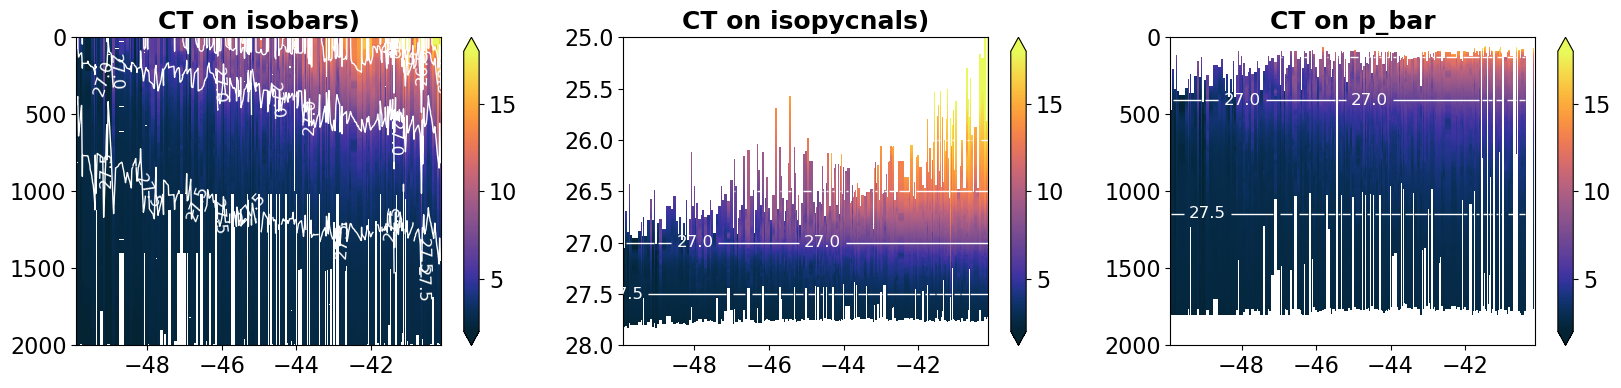

In [91]:
plt.figure(figsize=(20,4))

plt.subplot(131)
section_x.CT.sortby(x).plot(x=x, y='depth', cmap=cmap, norm=norm, add_labels=False)
contours1 = plt.contour(section_x.LATITUDE.values, section_x.depth.values, section_x.SIG0.values.T, levels=[26,26.5,27,27.5], colors='white', linewidths=1)
plt.clabel(contours1, inline=True, fontsize=12, fmt="%.1f")
plt.gca().invert_yaxis()
plt.title('CT on isobars')

plt.subplot(132)
section_rho.CT.sortby(x).plot(x=x, y='density', cmap=cmap, norm=norm, add_labels=False)
contours2 = plt.contour(section_rho.LATITUDE.values, section_rho.density.values, section_rho.SIG0.values.T, levels=[26,26.5,27,27.5], colors='white', linewidths=1)
plt.clabel(contours2, inline=True, fontsize=12, fmt="%.1f")
plt.ylim(28,25)
plt.title('CT on isopycnals')

plt.subplot(133)
section_pmean.CT.sortby(x).plot(x=x, y='pmean', cmap=cmap, norm=norm, add_labels=False)
contours3 = plt.contour(section_pmean.LATITUDE.values, section_pmean.pmean.values, section_pmean.SIG0.values.T, levels=[26,26.5,27,27.5], colors='white', linewidths=1)
plt.clabel(contours3, inline=True, fontsize=12, fmt="%.1f")
plt.gca().invert_yaxis()
plt.title('CT on p_bar');

## P_mean First: Variance Calculations

### Mesoscale Variance Production

In [199]:
K_rho = xr.open_dataset('/swot/SUM05/amf2288/global_diff.nc').K

In [200]:
K_rho_sel_x = K_rho.sel(lon_c=ds.LONGITUDE.mean(), lat_c=ds.LATITUDE.mean(), method='nearest')
K_rho_sel_x = K_rho_sel_x.interp(z_c=ds.pmean)

In [166]:
lfilt=100
rho_grid = np.arange(21,29,0.0025)
ct_m_pf = ff.ds_filt_single(section_pmean, lfilt, variable='CT', dim1='prof', dim2='pmean')
sa_m_pf = ff.ds_filt_single(section_pmean, lfilt, variable='SA', dim1='prof', dim2='pmean')
sp_m_pf = ff.ds_filt_single(section_pmean, lfilt, variable='SPICE', dim1='prof', dim2='pmean')

In [147]:
ct_e_pf = section_pmean.CT - ct_m_pf
sa_e_pf = section_pmean.SA - sa_m_pf
sp_e_pf = section_pmean.SPICE - sp_m_pf

In [148]:
ct_e_z2_pf = ct_e_pf.differentiate(coord='pmean')**2
sa_e_z2_pf = sa_e_pf.differentiate(coord='pmean')**2
sp_e_z2_pf = sp_e_pf.differentiate(coord='pmean')**2

In [149]:
ct_e_z2_filt_pf = ff.da_filt_single(ct_e_z2_pf, lfilt, dim1='prof', dim2='pmean')
sa_e_z2_filt_pf = ff.da_filt_single(sa_e_z2_pf, lfilt, dim1='prof', dim2='pmean')
sp_e_z2_filt_pf = ff.da_filt_single(sp_e_z2_pf, lfilt, dim1='prof', dim2='pmean')

In [150]:
ct_var2_pf = ct_e_z2_filt_pf
sa_var2_pf = sa_e_z2_filt_pf
sp_var2_pf = sp_e_z2_filt_pf

In [151]:
ct2_VPR_pf = K_rho_sel_x*ct_var2_pf
sa2_VPR_pf = K_rho_sel_x*sa_var2_pf
sp2_VPR_pf = K_rho_sel_x*sp_var2_pf

### Microscale Variance Production

In [152]:
ct_m_z2_pf = ct_m_pf.differentiate(coord='pmean')**2
sa_m_z2_pf = sa_m_pf.differentiate(coord='pmean')**2
sp_m_z2_pf = sp_m_pf.differentiate(coord='pmean')**2

In [153]:
ct_var3_pf = ct_m_z2_pf
sa_var3_pf = sa_m_z2_pf
sp_var3_pf = sp_m_z2_pf

In [154]:
ct3_VPR_pf = K_rho_sel_x*ct_var2_pf
sa3_VPR_pf = K_rho_sel_x*sa_var2_pf
sp3_VPR_pf = K_rho_sel_x*sp_var2_pf

## P_mean Last: Variance Calculations

In [162]:
def interp_to_rho(rho_profile, var_profile, rho_grid, flag='group'):
    
    valid = ~np.isnan(rho_profile) & ~np.isnan(var_profile)
    rho_nonan = rho_profile[valid]
    var_nonan = var_profile[valid]

    if len(rho_nonan) < 3 or len(var_nonan) < 3:
        return np.full_like(rho_grid, np.nan)

    if flag == 'group':
        _, idx = np.unique(rho_nonan, return_index=True)
        rho_nonan = rho_nonan[idx]
        var_nonan = var_nonan[idx]

    fvar = interpolate.PchipInterpolator(rho_nonan, var_nonan, extrapolate=False)
    return fvar(rho_grid)

In [186]:
def get_ds_rho(ds_z, da_SIG0, rho_grid, variables, dim1='N_PROF', dim2='PRES_INTERPOLATED'):

    xrs = []
    rho_size = rho_grid.size
    
    for var in variables:
        var_interp = xr.apply_ufunc(interp_to_rho, da_SIG0, ds_z[var],
            input_core_dims=[[dim2], [dim2]],
            output_core_dims=[['rho_grid']],
            dask_gufunc_kwargs={'output_sizes': {'rho_grid': rho_size}},
            vectorize=True,
            dask='parallelized',
            kwargs={'rho_grid': rho_grid},
            output_dtypes=[ds_z[var].dtype])
        print(f'Completed comp for {var}')
        var_interp = xr.DataArray(
            data=var_interp.data,
            dims=[dim1, 'rho_grid'],
            coords={'rho_grid': rho_grid, dim1: ds_z[dim1]},
            name=var)
        xrs.append(var_interp)
        print(f'Completed {var}')
    
    ds_rho = xr.merge(xrs)
    print(f'Completed merge')
    #ds_rho = ds_rho.assign_coords(TIME      =(dim1, ds_z.TIME.data))
    ds_rho = ds_rho.assign_coords(LATITUDE  =(dim1, ds_z.LATITUDE.data))
    ds_rho = ds_rho.assign_coords(LONGITUDE =(dim1, ds_z.LONGITUDE.data))
    
    return ds_rho

### Mesoscale Variance Production

In [242]:
K_rho = xr.open_dataset('/swot/SUM05/amf2288/var-boxes/K_rho_3dx.nc').K_filt_3dx

In [245]:
K_rho_sel_rho = K_rho.sel(lon=ds.LONGITUDE.mean(), lat=ds.LATITUDE.mean(), method='nearest')

In [246]:
ct_m_pl = ff.ds_filt_single(section_x, lfilt, variable='CT', dim1='prof', dim2='depth')
sa_m_pl = ff.ds_filt_single(section_x, lfilt, variable='SA', dim1='prof', dim2='depth')
sp_m_pl = ff.ds_filt_single(section_x, lfilt, variable='SPICE', dim1='prof', dim2='depth')

In [247]:
ct_e_pl = section_x.CT - ct_m_pl
sa_e_pl = section_x.SA - sa_m_pl
sp_e_pl = section_x.SPICE - sp_m_pl

In [248]:
ct_e_z2_pl = ct_e_pl.differentiate(coord='depth')**2
sa_e_z2_pl = sa_e_pl.differentiate(coord='depth')**2
sp_e_z2_pl = sp_e_pl.differentiate(coord='depth')**2

In [249]:
ct_e_z2_filt_pl = ff.da_filt_single(ct_e_z2_pl, lfilt, dim1='prof', dim2='depth')
sa_e_z2_filt_pl = ff.da_filt_single(sa_e_z2_pl, lfilt, dim1='prof', dim2='depth')
sp_e_z2_filt_pl = ff.da_filt_single(sp_e_z2_pl, lfilt, dim1='prof', dim2='depth')

In [250]:
ct_e_z2_filt_pl.name = 'ct_e_z2_filt_pl'
ct_e_z2_filt_pl = ct_e_z2_filt_pl.to_dataset()

sa_e_z2_filt_pl.name = 'sa_e_z2_filt_pl'
sa_e_z2_filt_pl = sa_e_z2_filt_pl.to_dataset()

sp_e_z2_filt_pl.name = 'sp_e_z2_filt_pl'
sp_e_z2_filt_pl = sp_e_z2_filt_pl.to_dataset()

In [264]:
ct_var2_pl = get_ds_rho(ct_e_z2_filt_pl, section_x.SIG0, rho_grid, ct_e_z2_filt_pl, dim1='prof', dim2='depth').rename({'rho_grid':'density'})
sa_var2_pl = get_ds_rho(sa_e_z2_filt_pl, section_x.SIG0, rho_grid, sa_e_z2_filt_pl, dim1='prof', dim2='depth').rename({'rho_grid':'density'})
sp_var2_pl = get_ds_rho(sp_e_z2_filt_pl, section_x.SIG0, rho_grid, sp_e_z2_filt_pl, dim1='prof', dim2='depth').rename({'rho_grid':'density'})

Completed comp for ct_e_z2_filt_pl
Completed ct_e_z2_filt_pl
Completed merge
Completed comp for sa_e_z2_filt_pl
Completed sa_e_z2_filt_pl
Completed merge
Completed comp for sp_e_z2_filt_pl
Completed sp_e_z2_filt_pl
Completed merge


In [266]:
ct2_VPR_pl = K_rho_sel_rho*ct_var2_pl
sa2_VPR_pl = K_rho_sel_rho*sa_var2_pl
sp2_VPR_pl = K_rho_sel_rho*sp_var2_pl

### Microscale Variance Production

In [268]:
ct_m_z2_pl = ct_m_pl.differentiate(coord='depth')**2
sa_m_z2_pl = sa_m_pl.differentiate(coord='depth')**2
sp_m_z2_pl = sp_m_pl.differentiate(coord='depth')**2

In [269]:
ct_m_z2_pl.name = 'ct_m_z2_pl'
ct_m_z2_pl = ct_m_z2_pl.to_dataset()

sa_m_z2_pl.name = 'sa_m_z2_pl'
sa_m_z2_pl = sa_m_z2_pl.to_dataset()

sp_m_z2_pl.name = 'sp_m_z2_pl'
sp_m_z2_pl = sp_m_z2_pl.to_dataset()

In [272]:
ct_var3_pl = get_ds_rho(ct_m_z2_pl, section_x.SIG0, rho_grid, ct_m_z2_pl, dim1='prof', dim2='depth').rename({'rho_grid':'density'})
sa_var3_pl = get_ds_rho(sa_m_z2_pl, section_x.SIG0, rho_grid, sa_m_z2_pl, dim1='prof', dim2='depth').rename({'rho_grid':'density'})
sp_var3_pl = get_ds_rho(sp_m_z2_pl, section_x.SIG0, rho_grid, sp_m_z2_pl, dim1='prof', dim2='depth').rename({'rho_grid':'density'})

Completed comp for ct_m_z2_pl
Completed ct_m_z2_pl
Completed merge
Completed comp for sa_m_z2_pl
Completed sa_m_z2_pl
Completed merge
Completed comp for sp_m_z2_pl
Completed sp_m_z2_pl
Completed merge


In [274]:
ct3_VPR_pl_rho = K_rho_sel_rho*ct_var3_pl
sa3_VPR_pl_rho = K_rho_sel_rho*sa_var3_pl
sp3_VPR_pl_rho = K_rho_sel_rho*sp_var3_pl

In [275]:
ct3_VPR_pf_rho['PRES'] = (('prof','density'), section_rho.PRES.data)
sa3_VPR_pf_rho['PRES'] = (('prof','density'), section_rho.PRES.data)
sp3_VPR_pf_rho['PRES'] = (('prof','density'), section_rho.PRES.data)

In [276]:
ct3_VPR_pf = get_ds_pmean(ct3_VPR_pf_rho, np.arange(0,2001,1001), ct3_VPR_pf_rho, dim1='prof', dim2='density')

ValueError: tuple.index(x): x not in tuple